In [1]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split,cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import time
import numpy as np

In [2]:
df = pd.read_csv("/kaggle/input/csgo-round-winner-classification/csgo_round_snapshots.csv")

X = df.drop(columns=['round_winner'])
X = pd.get_dummies(X)
y = df['round_winner']
y = y.map({'CT': 1, 'T': 0}).astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [3]:
import time
start = time.time()
classfier = LGBMClassifier()
classfier.fit(X=X_train, y=Y_train.values.ravel())
predicted=classfier.predict(X_test)
print('Classification of the result is:')
print(f1_score(Y_test, predicted))
end = time.time()
print('Execution time is:')
print(end - start)

Classification of the result is:
0.7855834815149022
Execution time is:
3.1062448024749756


## Parametry modelu Lightgbm Classifier
- num_leaves : Parametr ten kontroluje złożoność modelu. Określa on maksymalną złożoność pojedynczego modelu w ramach boostingu. Nieadekwatnie duże wartości tego parametru mogą powodować tak zwany overfitting. natomiast jego zbyt małe wartości niewystarczająco skomplikowany model
![](https://ichi.pro/assets/images/max/724/1*AZsSoXb8lc5N6mnhqX5JCg.png)
- num_iterations : Parametr ten określa, przez ile iteracji model boostingowy będzie trenowyany. Ma to wypływ an dokładność modelu i czas trenowania, ale zwiesza szanse na overfitting.
- max_depth : Ten parametr określa maksymalną głębokość drzewa. Konsekwencji w przypadku jego niewystarczającej wartości są takie same jak w przypadku num_leaves. Ponadto parametr ten wpływa na czas treningu, jak i optymalną wartość num_leaves, jako iż są one od siebie zależne.
- learning_rate : Parametr ten określa, jak bardzo błąd zostanie poprawiony w przypadku pojedynczej iteracji. Przy niskim learning rate i dużej liczbie iteracji współczynnik ten zwiększy dokładność modelu przy skomplikowanych danych.
- reg_alpha : Parametr ten odpowiada za regularyzacje cech pod względem ich przydatności. Im cech proporcjonalnie mniej przydatna, tym mniej będzie brana pod uwagę przy budowie modelu.


In [4]:
lgb=LGBMClassifier()
start = time.time()
#Define the parameters
parameters = {'num_leaves':[1000,1250,1500], 'num_iterations':[50,100,150],'max_depth':[-1],
             'learning_rate':[0.05,0.1,0.15],'reg_alpha':[0.01]}
parameters['random_state']=[42]

## [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
GridsearchCV należy do tak zwanych wyczerpujących wyszukiwań. Oznacza to, iż przeszukiwane są wszystkie kombinacje parametró by wybrać ten najlepszy. Ma to wady w postaci długiego czasu wyszukiwań jak i wyższej szansy na tak zwany overfitting poprzez parametry. Do zalet grid searchu należy jego możliwość urównoregleania, gdyż następna iteracja nie zależy od poprzedniej.
## [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
RandomizedSearchCV Jest to metoda optymalizacji losująca wybrane parametry z określonej dystrybucji. W przypadku braku określenia dystrybucji wybierana jest tak zwana dystrybucja równomierna. Sposób ten może dawać lepsze rezultaty w przypadku gdy istnieją niepowiązane lub też mało ważne cechy, gdyż każde nowe losowanie będzie najprawdopodobniej zawierać inną wartość ważnych zmiennych.

![](https://miro.medium.com/max/1838/1*o2rMCJKUcpqRBFfHZ3Jkfg.png)

In [5]:
#Define the scoring
gscv=GridSearchCV(lgb,parameters,scoring='accuracy',verbose=0,n_jobs=-1)
gscv.fit(X=X_train, y=Y_train.values.ravel())
print(gscv.best_params_)
predicted=gscv.predict(X_test)
print('Classification of the result is:')
print(f1_score(Y_test, predicted))
end = time.time()
print('Execution time is:')
print(end - start)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'learning_rate': 0.15, 'max_depth': -1, 'num_iterations': 150, 'num_leaves': 1000, 'random_state': 42, 'reg_alpha': 0.01}
Classification of the result is:
0.891667356683503
Execution time is:
646.4117321968079


In [6]:
rscv=RandomizedSearchCV(lgb,parameters,scoring='accuracy',n_iter=10,verbose=0,n_jobs=-1)
rscv.fit(X=X_train, y=Y_train.values.ravel())
print(rscv.best_params_)
predicted=rscv.predict(X_test)
print('Classification of the result is:')
print(f1_score(Y_test, predicted))
end = time.time()
print('Execution time is:')
print(end - start)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'reg_alpha': 0.01, 'random_state': 42, 'num_leaves': 1250, 'num_iterations': 150, 'max_depth': -1, 'learning_rate': 0.15}
Classification of the result is:
0.8936087941225211
Execution time is:
878.5368049144745


## [Hyperopt](https://hyperopt.github.io/hyperopt/#documentation)
Ostatnią omówioną metodą jest hyperopt - biblioteka polegająca na bayesowskim podejściu do optymalizacji. Podejście to polega na uwzględnianiu poprzednich wartość funkcji straty dla wybranych parametrów. Dzieje się to dzięki tworzeniu modelu probabilistycznego bazującego na wybranych obserwacjach i próbie przewidzenia następnego zestawu parametrów bardziej odpowiedniego dla wybranego problemu. Tworzona funkcja nazywana jest funkcja zastępcza/modelem zastępczym, gdyż stara się ona przewidzieć zachowanie modelu, bazując na parametrach, pomijając jego faktyczne działanie.
<br>


![](https://miro.medium.com/max/875/1*01OV9s_DYaK8k-cwa0bk3A.png)

<br>

![](https://miro.medium.com/max/875/1*31TpvO5XO_VGaZG0m3FgVg.png)

In [7]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

lgb_reg_params = {
    'num_leaves':            hp.choice('num_leaves', np.arange(500, 2000, 1, dtype=int)),
    'min_child_samples':     hp.choice('num_iterations', np.arange(40, 3001, dtype=int)),
    'max_depth':             hp.choice('max_depth',np.arange(1, 200, 1, dtype=int)),
    'learning_rate':         hp.uniform('learning_rate',0.05,0.3),
    'reg_alpha':             hp.uniform('reg_alpha',0.005,0.05),
}




def f(params):
    global X_train,y_train
    params['random_state']=42
    cumulative_f1_score = []
    lgbm = LGBMClassifier(n_jobs=-1,early_stopping_rounds=None,**params)
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    X,y = X_train.values , Y_train.values
    
    
    for train_index, test_index in skf.split(X, y):
        X_train_, X_test_ = X[train_index], X[test_index]
        y_train_, y_test_ = y[train_index], y[test_index]
        lgbm.fit(X_train_,y_train_)
        cumulative_f1_score.append(f1_score(lgbm.predict(X_test_),y_test_))
        

    return 1 - np.array(cumulative_f1_score).mean()

trials = Trials()
result = fmin(
    fn=f,                           # objective function
    space=lgb_reg_params,   # parameter space
    algo=tpe.suggest,               # surrogate algorithm
    max_evals=6,                # no. of evaluations
    trials=trials                   # trials object that keeps track of the sample results (optional)
)
print(result)

  0%|          | 0/6 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.p

 17%|█▋        | 1/6 [00:18<01:30, 18.12s/trial, best loss: 0.18978822302092646]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.p

 33%|███▎      | 2/6 [00:29<00:56, 14.19s/trial, best loss: 0.18978822302092646]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.p

 50%|█████     | 3/6 [00:42<00:41, 13.76s/trial, best loss: 0.18978822302092646]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.p

 67%|██████▋   | 4/6 [01:01<00:31, 15.66s/trial, best loss: 0.16270248171666724]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.p

 83%|████████▎ | 5/6 [01:14<00:14, 14.80s/trial, best loss: 0.16270248171666724]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.p

100%|██████████| 6/6 [01:27<00:00, 14.54s/trial, best loss: 0.16270248171666724]
{'learning_rate': 0.2796625776088632, 'max_depth': 49, 'num_iterations': 231, 'num_leaves': 759, 'reg_alpha': 0.015745385650593965}


In [8]:
import time
start = time.time()
hs = LGBMClassifier(**result)
hs.fit(X=X_train, y=Y_train.values.ravel())
predicted=hs.predict(X_test)
print('Classification of the result is:')
print(f1_score(Y_test, predicted))
end = time.time()
print('Execution time is:')
print(end - start)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Classification of the result is:
0.8954803040774015
Execution time is:
15.540251731872559


In [9]:
result

{'learning_rate': 0.2796625776088632,
 'max_depth': 49,
 'num_iterations': 231,
 'num_leaves': 759,
 'reg_alpha': 0.015745385650593965}

In [10]:
params = {'reg_alpha': 0.01, 'num_leaves': 1000, 'min_child_samples': 15, 'max_depth': -1, 'learning_rate': 0.15}

In [11]:
start = time.time()
classfier = LGBMClassifier(**params)
classfier.fit(X=X_train, y=Y_train.values.ravel())
predicted=classfier.predict(X_test)
print('Classification of the result is:')
print(accuracy_score(Y_test, predicted))
end = time.time()
print('Execution time is:')
print(end - start)

Classification of the result is:
0.8882716553658471
Execution time is:
9.308253765106201


In [12]:
!pip install shap==0.35.0

     |████████████████████████████████| 273 kB 4.5 MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-linux_x86_64.whl size=399184 sha256=6473c2f19a4dbe4e900412cb80cae3245517473623a664d25db6dd084a967980
  Stored in directory: /root/.cache/pip/wheels/c3/e0/82/26cebc699e23c6a1b9963981e1a10ed7de75db012f4af12428
Successfully built shap
  Attempting uninstall: shap
    Found existing installation: shap 0.39.0
    Uninstalling shap-0.39.0:
      Successfully uninstalled shap-0.39.0


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import shap
shap.initjs()

In [14]:
explainer = shap.TreeExplainer(classfier)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [15]:
shap_values = explainer.shap_values(X_test)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
LightGBM binary classifier with TreeExplainer shap values output has changed to a list o

In [16]:
shap_values[1].shape

(36723, 103)

In [17]:
X_test.shape

(36723, 103)

In [18]:
len(shap_values[1][0])

103

In [19]:
np.mean(Y_test)

0.490183263894562

In [20]:
explainer.expected_value

[0.2600495967680887, -0.2600495967680887]

In [21]:
proba = classfier.predict_proba(X_test)

In [22]:
proba

array([[9.83139441e-01, 1.68605586e-02],
       [5.42906923e-02, 9.45709308e-01],
       [1.07598647e-04, 9.99892401e-01],
       ...,
       [6.71903431e-02, 9.32809657e-01],
       [1.24092053e-03, 9.98759079e-01],
       [4.84877726e-01, 5.15122274e-01]])

In [23]:
i = 0
print(f"Predicted class: {predicted[i]}")
print(f"Predicted probabilities: {proba[i]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])

Predicted class: 0
Predicted probabilities: [0.98313944 0.01686056]


In [24]:
i = 1
print(f"Predicted class: {predicted[i]}")
print(f"Predicted probabilities: {proba[i]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])

Predicted class: 1
Predicted probabilities: [0.05429069 0.94570931]


In [25]:
i = 2
print(f"Predicted class: {predicted[i]}")
print(f"Predicted probabilities: {proba[i]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])


Predicted class: 1
Predicted probabilities: [1.07598647e-04 9.99892401e-01]


Predicted class: 1
Predicted probabilities: [1.07598647e-04 9.99892401e-01]


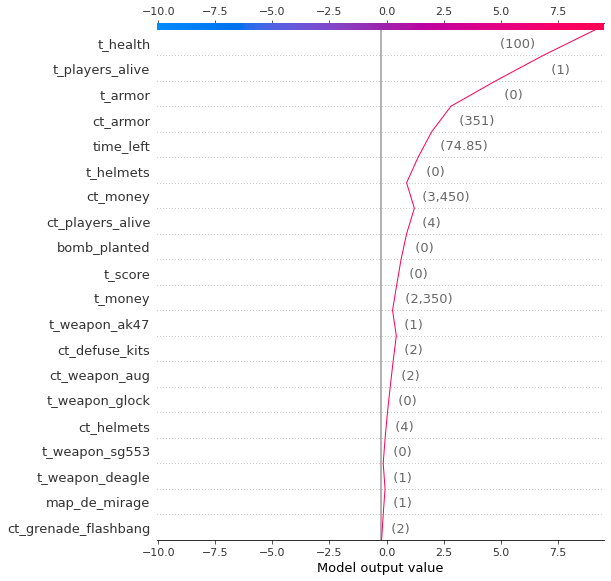

In [26]:
i = 2
print(f"Predicted class: {predicted[i]}")
print(f"Predicted probabilities: {proba[i]}")
shap.decision_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])

In [27]:
i = 27091
print(f"Predicted class: {predicted[i]}")
print(f"Predicted probabilities: {proba[i]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])


Predicted class: 0
Predicted probabilities: [0.71123989 0.28876011]


Predicted class: 0
Predicted probabilities: [0.71123989 0.28876011]


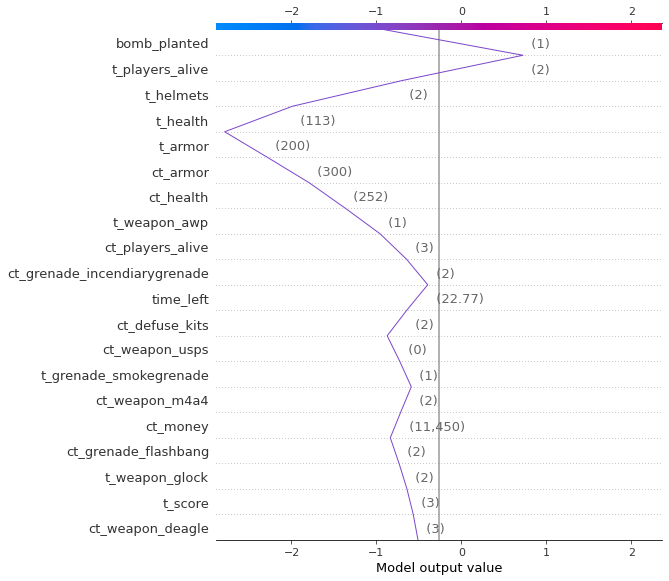

In [28]:
i = 27091
print(f"Predicted class: {predicted[i]}")
print(f"Predicted probabilities: {proba[i]}")
shap.decision_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])

Predicted class: 0
Predicted probabilities: [0.71123989 0.28876011]


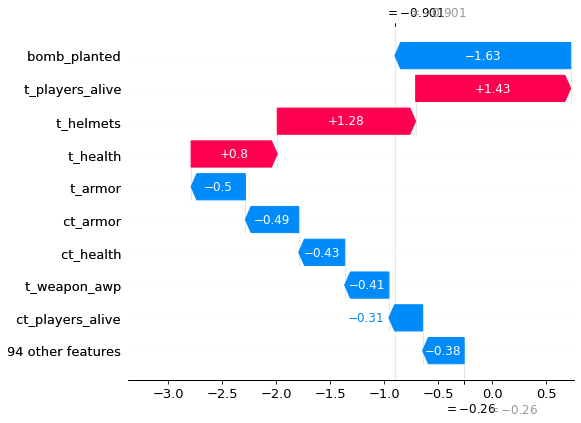

In [29]:
i = 27091
print(f"Predicted class: {predicted[i]}")
print(f"Predicted probabilities: {proba[i]}")
shap.waterfall_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])

In [30]:
len(shap_values)

2

In [31]:
X_test.iloc[i,:]

time_left          22.77
ct_score             8.0
t_score              3.0
bomb_planted        True
ct_health          252.0
                   ...  
map_de_mirage          0
map_de_nuke            0
map_de_overpass        1
map_de_train           0
map_de_vertigo         0
Name: 11973, Length: 103, dtype: object

In [32]:
proba

array([[9.83139441e-01, 1.68605586e-02],
       [5.42906923e-02, 9.45709308e-01],
       [1.07598647e-04, 9.99892401e-01],
       ...,
       [6.71903431e-02, 9.32809657e-01],
       [1.24092053e-03, 9.98759079e-01],
       [4.84877726e-01, 5.15122274e-01]])

In [33]:
abs(proba[:,0]-.5)

array([0.48313944, 0.44570931, 0.4998924 , ..., 0.43280966, 0.49875908,
       0.01512227])

In [34]:
np.argsort(abs(proba[:,0]-.5))


array([35079, 18845, 11634, ..., 18972, 30262, 29165])

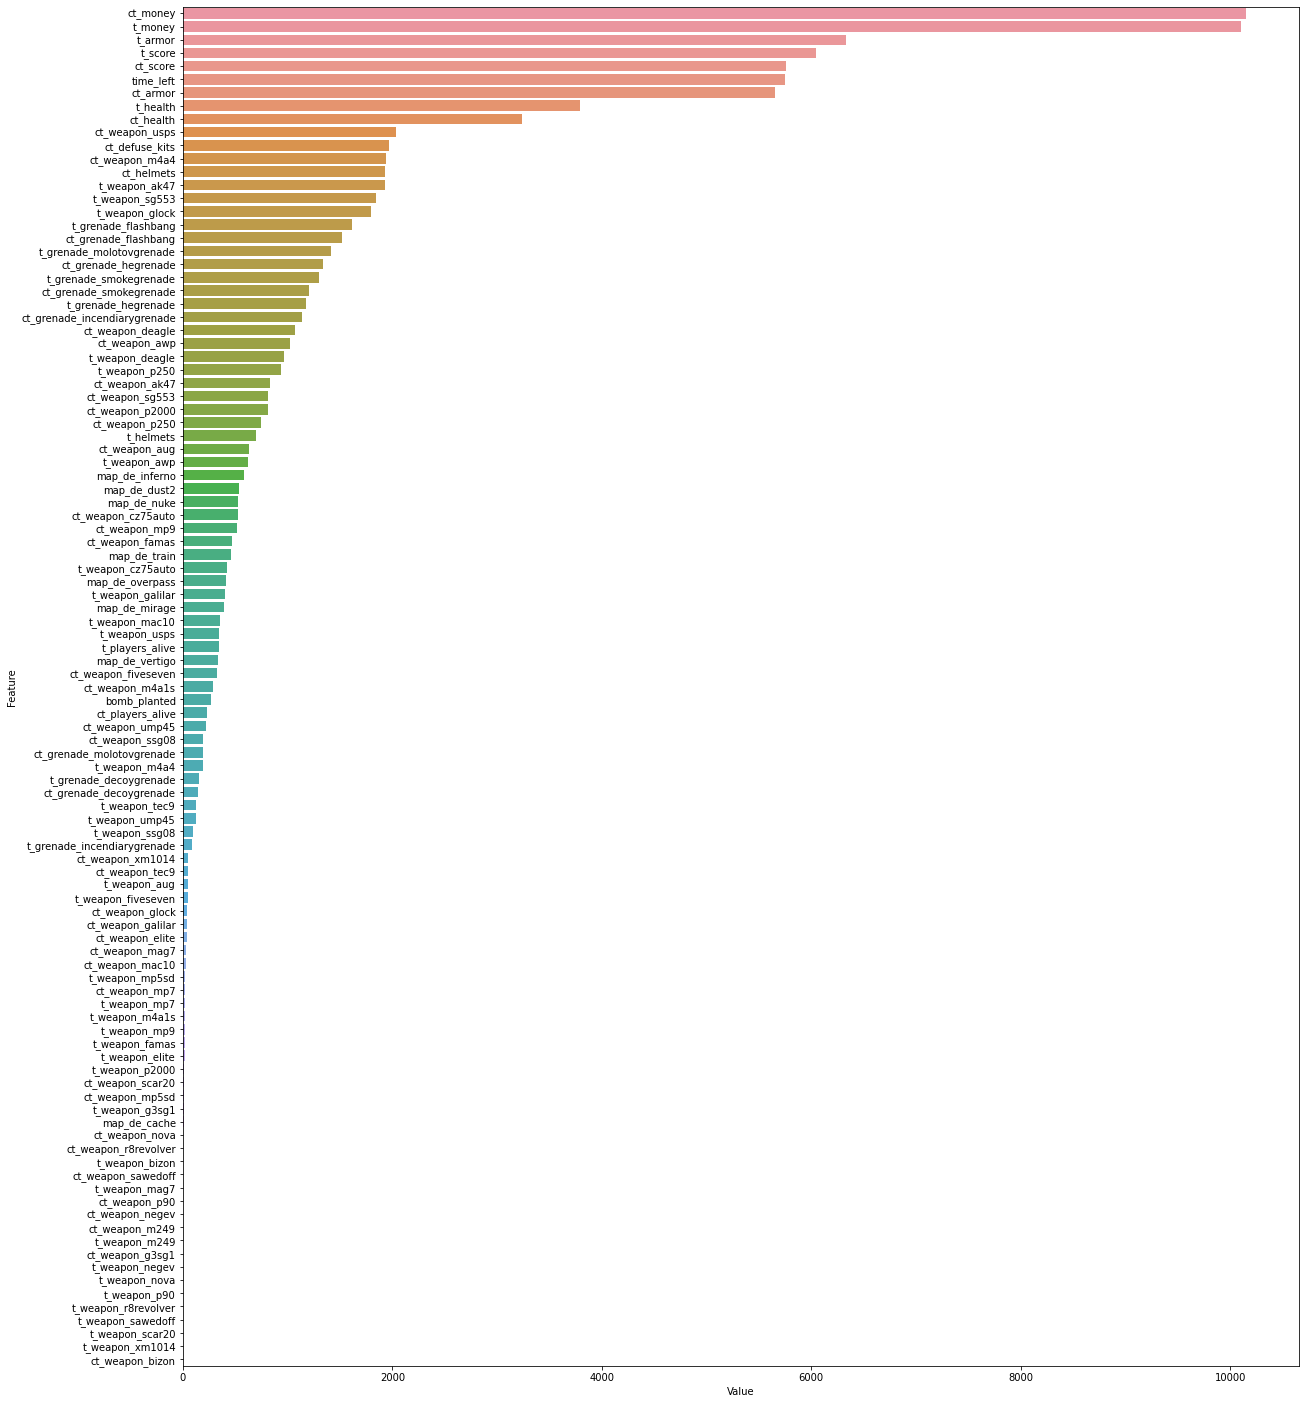

In [35]:
feature_imp = pd.DataFrame(sorted(zip(classfier.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 25))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.show()

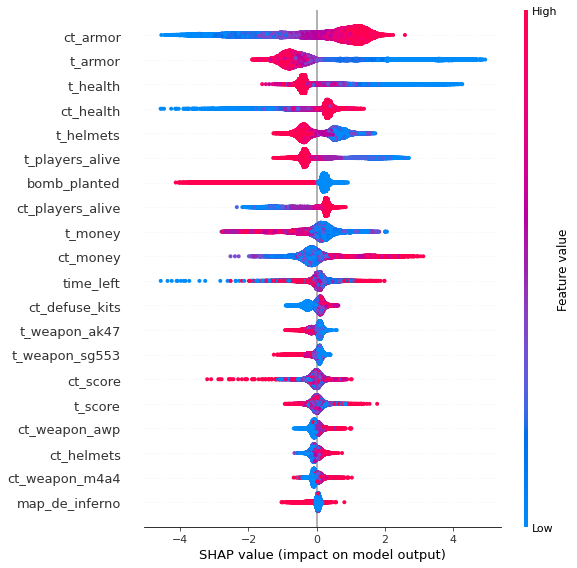

In [36]:
shap.summary_plot(shap_values[1], X_test)

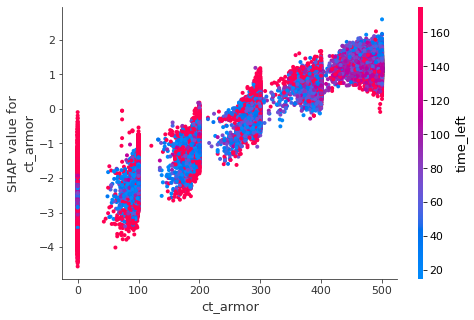

In [37]:
shap.dependence_plot('ct_armor', shap_values[1], X_test)

In [38]:
X_test.columns

Index(['time_left', 'ct_score', 't_score', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money',
       ...
       'ct_grenade_decoygrenade', 't_grenade_decoygrenade', 'map_de_cache',
       'map_de_dust2', 'map_de_inferno', 'map_de_mirage', 'map_de_nuke',
       'map_de_overpass', 'map_de_train', 'map_de_vertigo'],
      dtype='object', length=103)